### Import libraries

In [0]:
import torch
from torchtext import data
from torchtext import datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4, 4)

**Set random state**

In [0]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Data loading and preprocessing

In [0]:
TEXT = data.Field(tokenize = 'spacy', stop_words = 'spacy.lang.en.stop_words.STOP_WORDS', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

**Build vocabulary**

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

### Model preparation and train/test

**Batches iterator**

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

**Class for statistics agregation**

In [0]:
class Mean(object):
    def __init__(self):
        self.values = []

    def compute(self):
        return sum(self.values) / len(self.values)

    def update(self, value):
        self.values.extend(np.reshape(value, [-1]))

    def reset(self):
        self.values = []

    def compute_and_reset(self):
        value = self.compute()
        self.reset()

        return value

 **LSTM model**
<br>Standard RNNs suffer from the vanishing gradient problem. LSTMs overcome this by having an extra recurrent state called a cell, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple gates which control the flow of information into and out of the memory.
<br>*BidirectionalRNN*: as well as having an RNN processing the words in the sentence from the first to the last (a forward RNN),  second RNN processing the words in the sentence from the last to the first (a backward RNN). 
<br> In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. Prediction is made using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence),  and the last hidden state from the backward RNN (obtained from the first word of the sentence).



In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))

**Accuracy mesuremnet**

In [0]:
def accuracy(a, b):
    return (a.float() == b.float()).float().mean()

**Train/test**

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [26]:
print(INPUT_DIM)
print(PAD_IDX)

25002
1


Copying the pre-trained word embeddings into the model embedding layer

In [0]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.1172e-01, -4.9659e-01,  1.6307e-01,  ...,  1.2647e+00,
         -2.7527e-01, -1.3254e-01],
        [-8.5549e-01, -7.2081e-01,  1.3755e+00,  ...,  8.2522e-02,
         -1.1314e+00,  3.9972e-01],
        [-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        ...,
        [ 8.1767e-04,  8.0741e-01,  5.7392e-01,  ..., -1.5313e-02,
         -3.3521e-01, -1.9680e+00],
        [-1.3265e-01, -5.9668e-01, -8.3711e-01,  ..., -8.5074e-01,
         -1.7154e+00,  4.6425e-01],
        [ 9.2039e-01,  1.0958e-01,  6.1859e-01,  ...,  1.1601e+00,
          6.3119e-01,  8.1174e-01]])

Initialize < unk > and < pad > to all zeros

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        ...,
        [ 8.1767e-04,  8.0741e-01,  5.7392e-01,  ..., -1.5313e-02,
         -3.3521e-01, -1.9680e+00],
        [-1.3265e-01, -5.9668e-01, -8.3711e-01,  ..., -8.5074e-01,
         -1.7154e+00,  4.6425e-01],
        [ 9.2039e-01,  1.0958e-01,  6.1859e-01,  ...,  1.1601e+00,
          6.3119e-01,  8.1174e-01]])


In [0]:
opt = torch.optim.Adam(model.parameters())
model = model.to(device)

In [0]:
stats = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

train_accs = Mean()
train_losses = Mean()
test_accs = Mean()
test_losses = Mean()

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, train loss 0.61, train acc 0.65, test loss 0.44, test acc 0.80


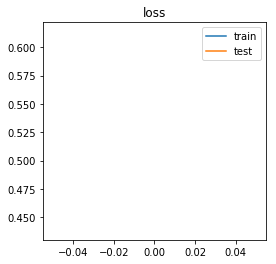

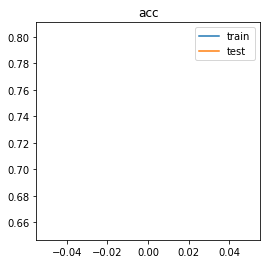

 20%|██        | 1/5 [02:25<09:40, 145.10s/it]

epoch 1, train loss 0.44, train acc 0.80, test loss 0.35, test acc 0.85


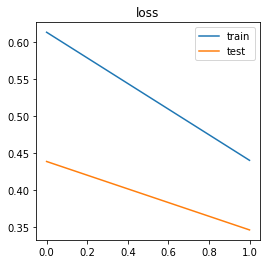

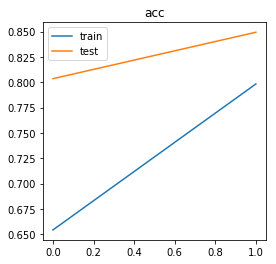

 40%|████      | 2/5 [04:50<07:15, 145.17s/it]

epoch 2, train loss 0.33, train acc 0.86, test loss 0.29, test acc 0.88


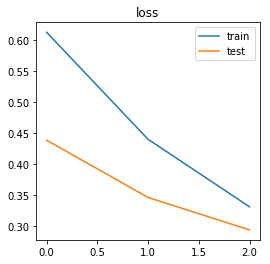

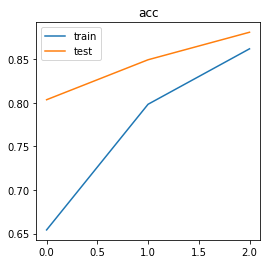

 60%|██████    | 3/5 [07:16<04:50, 145.37s/it]

epoch 3, train loss 0.28, train acc 0.88, test loss 0.27, test acc 0.89


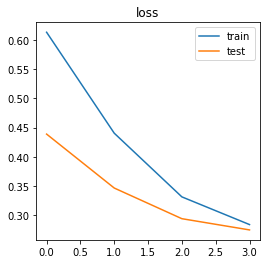

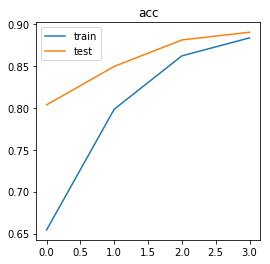

 80%|████████  | 4/5 [09:41<02:25, 145.22s/it]

epoch 4, train loss 0.24, train acc 0.91, test loss 0.26, test acc 0.90


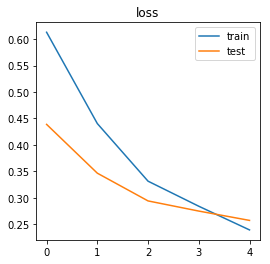

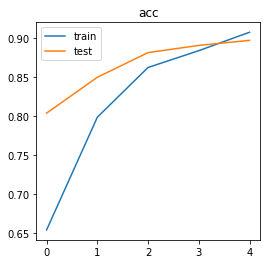

100%|██████████| 5/5 [12:06<00:00, 145.17s/it]


In [0]:
for epoch in tqdm(range(5)):
    model.train()
    for batch in train_iterator:
        text, text_lengths = batch.text
        
        logits = model(text, text_lengths).squeeze(1)
        
        train_loss = F.binary_cross_entropy_with_logits(input=logits, target=batch.label)
        train_acc = accuracy(batch.label, logits > 0.)
        
        train_losses.update(train_loss.data.cpu().numpy())
        train_accs.update(train_acc.data.cpu().numpy())
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
    with torch.no_grad():
      model.eval()
      
      for batch in test_iterator:
        text, text_lengths = batch.text
        
        logits = model(text, text_lengths).squeeze(1)
        
        test_loss = F.binary_cross_entropy_with_logits(input=logits, target=batch.label)
        test_acc = accuracy(batch.label, logits > 0.)
        
        test_losses.update(test_loss.data.cpu().numpy())
        test_accs.update(test_acc.data.cpu().numpy())
        
    train_loss = train_losses.compute_and_reset()
    train_acc = train_accs.compute_and_reset()
    test_loss = test_losses.compute_and_reset()
    test_acc = test_accs.compute_and_reset()
    
    print('epoch {}, train loss {:.2f}, train acc {:.2f}, test loss {:.2f}, test acc {:.2f}'.format(epoch, train_loss, train_acc, test_loss, test_acc))

    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    stats['test_loss'].append(test_loss)
    stats['test_acc'].append(test_acc)

    plt.plot(stats['train_loss'], label='train')
    plt.plot(stats['test_loss'], label='test')     
    plt.title('loss')
    plt.legend()
    plt.show()

    plt.plot(stats['train_acc'], label='train')
    plt.plot(stats['test_acc'], label='test')
    plt.title('acc')
    plt.legend()
    plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'lstm.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import dill
with open("/content/gdrive/My Drive/TEXT.Field","wb")as f:
     dill.dump(TEXT,f)